In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Walmart_Sales.csv')
df.sample(10)

FileNotFoundError: [Errno 2] No such file or directory: 'Walmart_Sales.csv'

1. Histogram

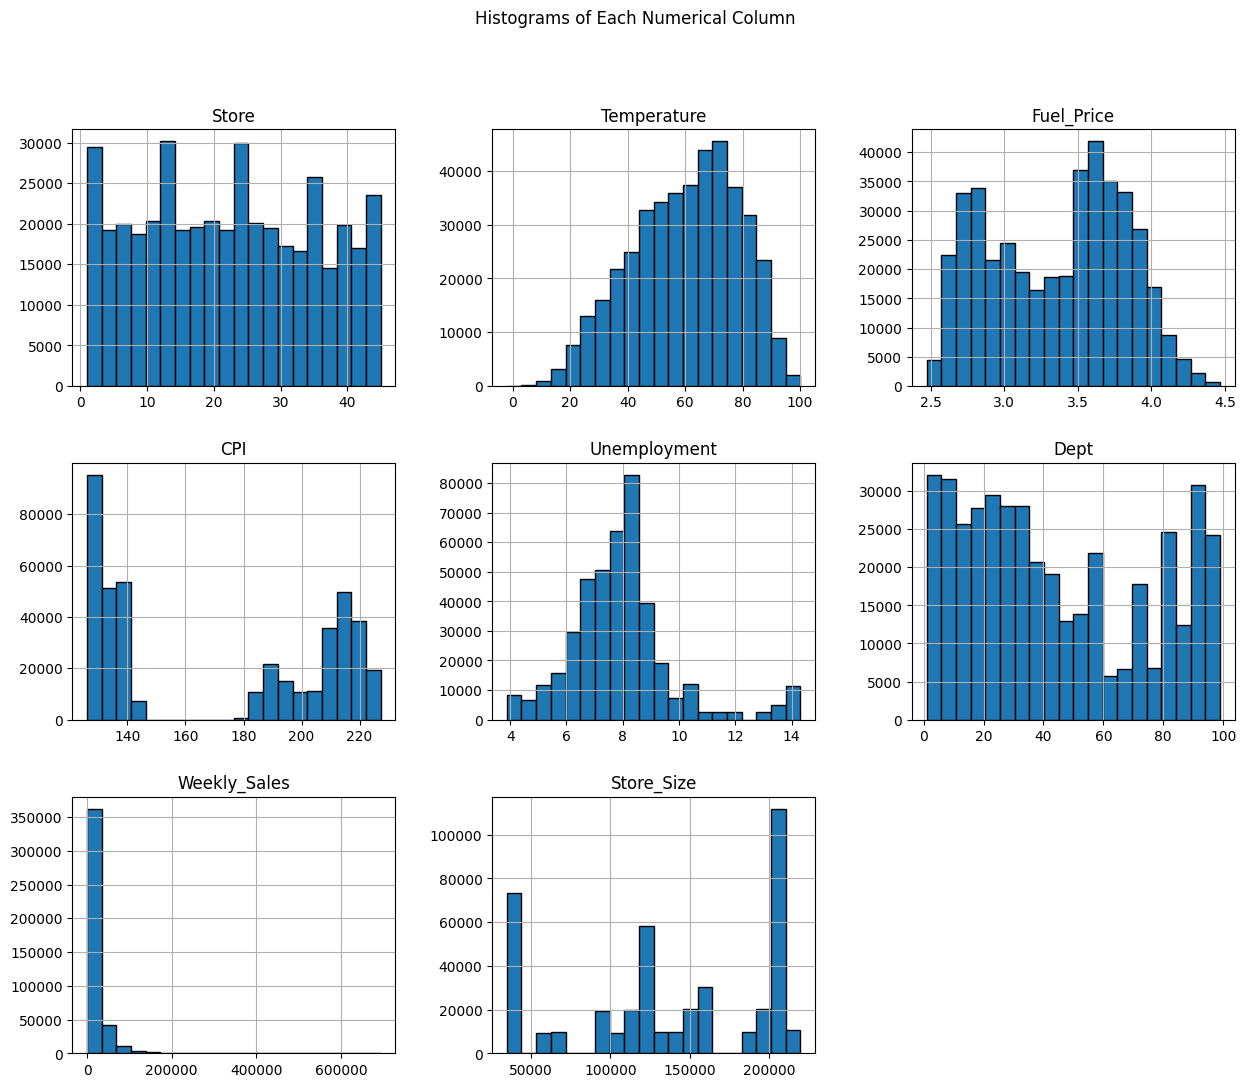

In [4]:
df.hist(bins=20, figsize=(15,12), edgecolor='black')
plt.suptitle('Histograms of Each Numerical Column')
plt.show()

2. Outliers in the dataset

Column: Store, Outliers Detected: 0
Column: Temperature, Outliers Detected: 67
Column: Fuel_Price, Outliers Detected: 0
Column: CPI, Outliers Detected: 0
Column: Unemployment, Outliers Detected: 32044
Column: Dept, Outliers Detected: 0
Column: Weekly_Sales, Outliers Detected: 35377
Column: Store_Size, Outliers Detected: 0


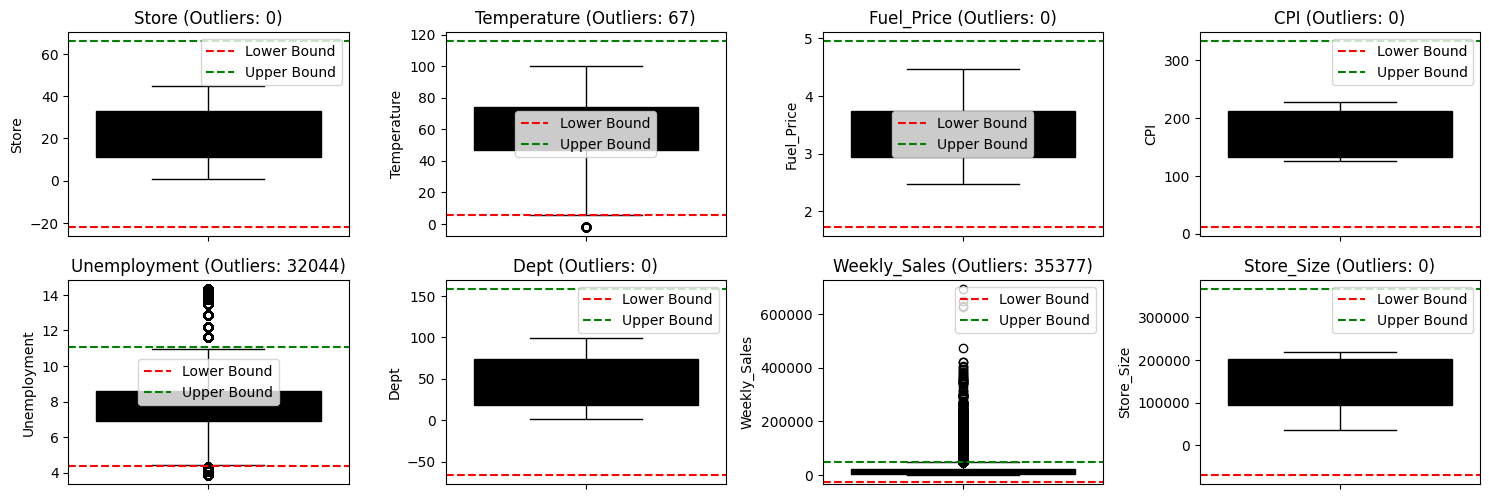

In [6]:
#Numerical columns
numerical_cols = df.select_dtypes(include='number').columns

#Outlier detection using IQR method 
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    Q1 = df[col].quantile(0.25) 
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR

    #Number of Outliers in each column
    outliers = df[(df[col] < lb) | (df[col] > ub)]
    print(f"Column: {col}, Outliers Detected: {len(outliers)}")

    #Boxplot of the outliers
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[col], color="black")
    plt.axhline(lb, color='red', linestyle='--', label='Lower Bound')
    plt.axhline(ub, color='green', linestyle='--', label='Upper Bound')
    plt.title(f'{col} (Outliers: {len(outliers)})')
    plt.legend()

plt.tight_layout()
plt.show()


3. Weekly sales each month

In [8]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

#Separating the date column into year, month & day
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

#Grouping Year & Month by weekly sales
Sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()

#Weekly Sales every month
plt.figure(figsize=(20, 10))
plt.plot(Sales['Year'].astype(str) + '-' + Sales['Month'].astype(str), 
         Sales['Weekly_Sales'], marker='o', color='g')
plt.title('Total Weekly Sales by Month')
plt.xlabel('Year/Month')
plt.ylabel('Sales/Week')
plt.grid(True)
plt.tight_layout()
plt.show()

4. Holiday v/s Non Holiday weeks

In [10]:
#Holiday & Non-Holiday Week
plt.figure(figsize=(5, 2.5))
sns.countplot(x='IsHoliday', data=df)
plt.title('Holiday & Non-Holiday Weeks')
plt.show()

5. Proportion of each store 

In [12]:
#Percentage of Each Store type
df['Store_Type'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(4, 4), startangle=90)
plt.title('Proportion of Each Store')
plt.ylabel('')
plt.show()

6. Proportion of each store

In [14]:
numerical_data = df.select_dtypes(include=['number'])
#Heatmap of Numerical Columns
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

7. Increase in Fuel prices overtime

In [16]:
#Change in Fuel Price 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fuel_Price', y='Date', data=df)
plt.title('Weekly Sales vs Fuel Price')
plt.show()

8. Sales of each store

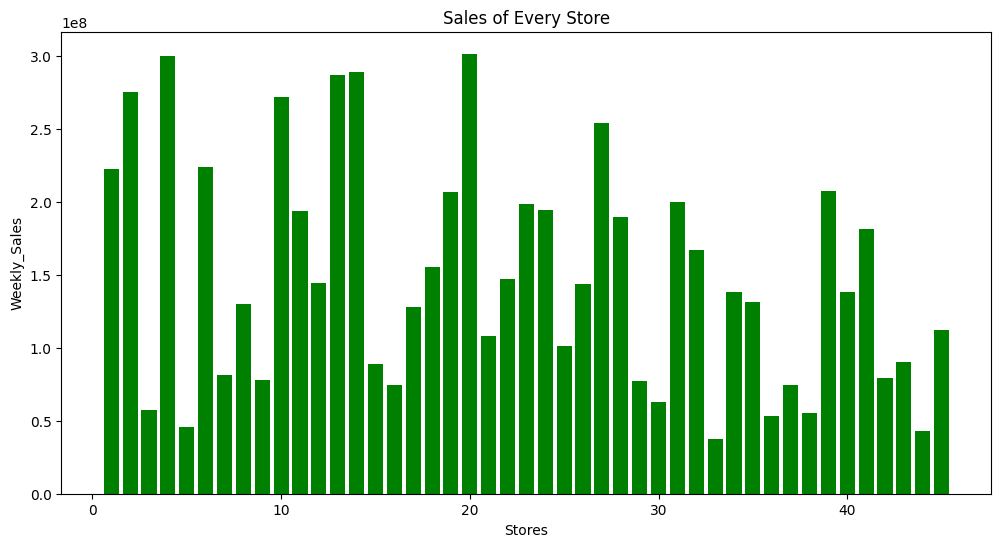

In [18]:
#Grouping the targeted columns
Store = df.groupby('Store')['Weekly_Sales'].sum().reset_index()

# Plot total sales by store
plt.figure(figsize=(12, 6))
plt.bar(Store['Store'], Store['Weekly_Sales'], color='green')
plt.title('Sales of Every Store')
plt.xlabel('Stores')
plt.ylabel('Weekly_Sales')
plt.show()

9. Sales of each department

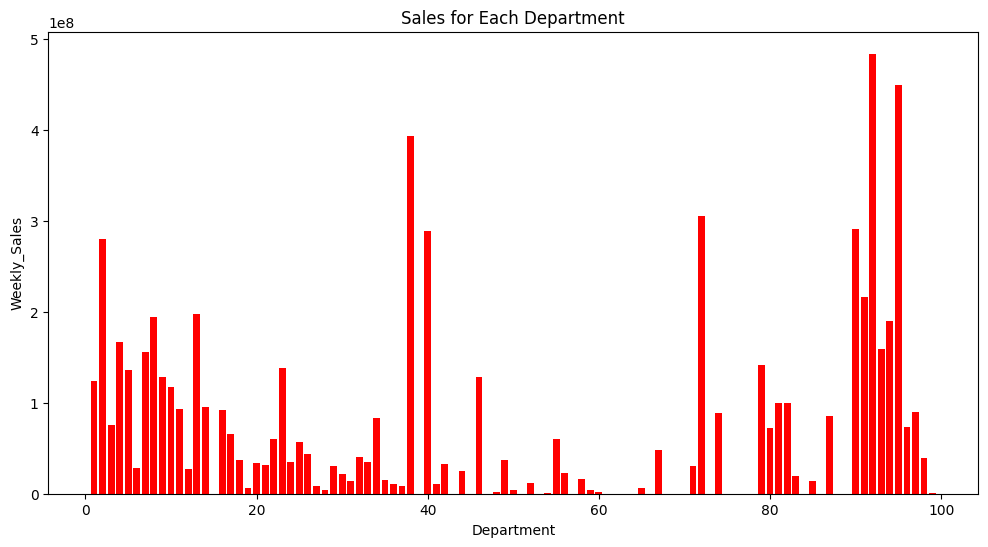

In [20]:
#Grouping the targeted columns
Department = df.groupby('Dept')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(Department['Dept'], Department['Weekly_Sales'], color='red')
plt.title('Sales for Each Department')
plt.xlabel('Department')
plt.ylabel('Weekly_Sales')
plt.show()

In [21]:
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest


T-test for holiday and non-holiday 

In [23]:
holiday_sales = df[df['IsHoliday'] == 1]['Weekly_Sales'] 
non_holiday_sales = df[df['IsHoliday'] == 0]['Weekly_Sales']  

#samples for t-test
t_stat, p_val = ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)
print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_val:.4f}")

#Interpreting the results
if p_val < 0.05:
    print("The difference in sales between holiday and non-holiday weeks is statistically significant.")
else:
    print("No significant difference in sales between holiday and non-holiday weeks.")


T-Statistic: 7.03, P-Value: 0.0000
The difference in sales between holiday and non-holiday weeks is statistically significant.


Time-Series Decomposition and Its Results

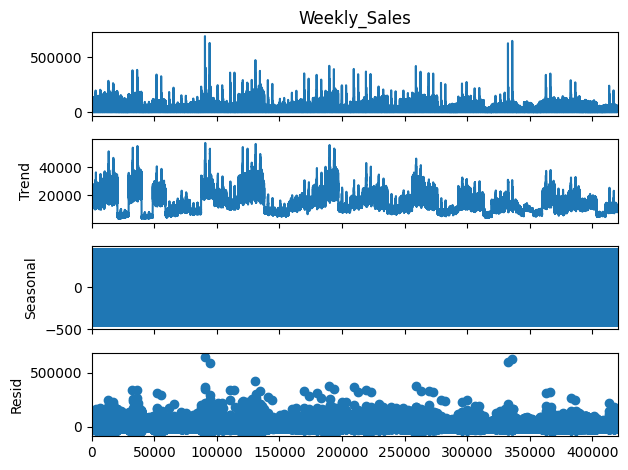

In [25]:

#time-series decomposition
decomposition = seasonal_decompose(df['Weekly_Sales'], model='additive', period=52)
decomposition.plot()
plt.show()


logical framework to approach business decisions based on the analysis

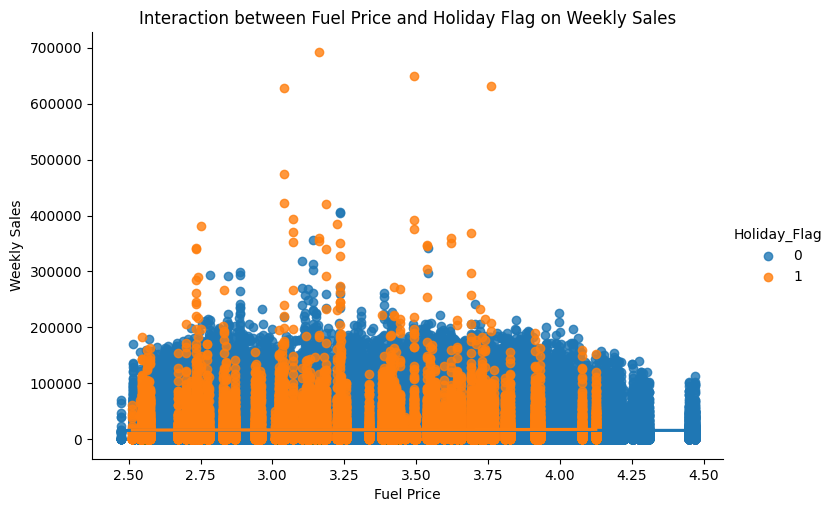

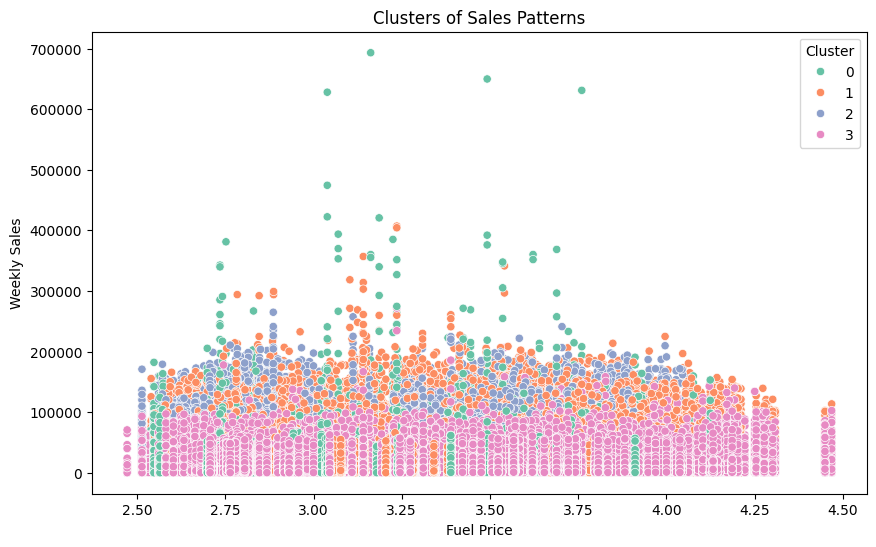

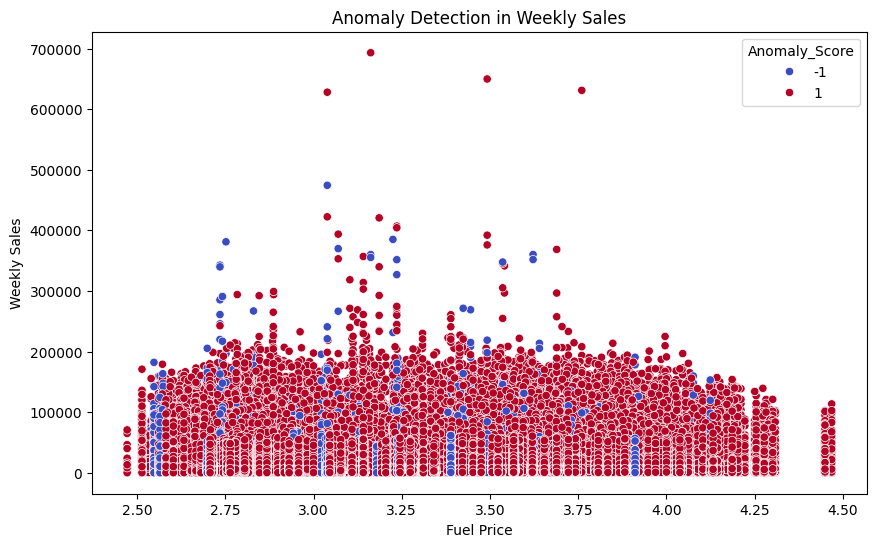

In [27]:

# Just to Ensure the 'Holiday_Flag' column exists
if 'Holiday_Flag' not in df.columns:
    if 'IsHoliday' in df.columns:
        df['Holiday_Flag'] = df['IsHoliday'].astype(int)  
    else:
        raise KeyError("Holiday flag column is missing. Ensure your data contains holiday indicators.")

#Segment the data into clusters
numerical_df = df.select_dtypes(include=['float64', 'int64'])
scaled_data = StandardScaler().fit_transform(numerical_df.drop(columns=['Weekly_Sales']))
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
numerical_df['Cluster'] = clusters

#Detect anomalies in the data
isolation_model = IsolationForest(contamination=0.05, random_state=42)
anomalies = isolation_model.fit_predict(numerical_df.drop(columns=['Weekly_Sales']))
numerical_df['Anomaly_Score'] = anomalies

#Interaction B/W Fuel Price and Holiday Flag
sns.lmplot(x='Fuel_Price', y='Weekly_Sales', hue='Holiday_Flag', data=df, aspect=1.5)
plt.title('Interaction between Fuel Price and Holiday Flag on Weekly Sales')
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.show()

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=numerical_df['Fuel_Price'], y=numerical_df['Weekly_Sales'], hue=numerical_df['Cluster'], palette='Set2')
plt.title('Clusters of Sales Patterns')
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.show()

# Visualizing anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=numerical_df['Fuel_Price'], y=numerical_df['Weekly_Sales'], hue=numerical_df['Anomaly_Score'], palette='coolwarm')
plt.title('Anomaly Detection in Weekly Sales')
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.show()
